# Epiretinal Model Fitting Notebook

Contains code for Beyeler2019 like evaluation based on area, eccentricity, and orientation, as well as Granley2021 like evaluation for scaling amplitude, frequency, and pulse duration on data from Nanduri2012, Weitz2015, Horsanger2009, and Greenwald2009.
Beyeler code currently does not use leave on electrode out cross validation. It is just for evaluating

## Setup Code

In [1]:
import shapes
import pulse2percept as p2p
from pulse2percept.stimuli import BiphasicPulseTrain
from pulse2percept.implants import ArgusII
from pulse2percept.utils import center_image, r2_score, circ_r2_score
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, Nanduri2012Model, MVGModel
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusI
from pulse2percept.datasets import load_nanduri2012
from pulse2percept.viz import scatter_correlation
from skimage import measure
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
h5_shapes = "/home/jgranley/shapes/data/shapes.h5"
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [2]:
### Helper class and functions to aggregate and plot results ###
class RegressionResults:
    def __init__(self, model=None, implant=None, name=None, subject=None):
        self.subject = subject
        self.model = model
        self.implant = implant
        self.name = name
        if self.name is None:
            self.name = str(model.__class__.__name__)
        
        # results (score or metric)
        self.results = {}
        # data on predictions vs true
        self.data = {}
        # any parameters used for the evaluation
        self.params = {}
        
    def add_results(self, runname, results, data, params):
        self.results[runname] = results
        self.data[runname] = data
        self.params[runname] = params

In [5]:
##### Beyeler 2019 evaluation #####           
def beyeler2019_eval(subject, implant, model, test_amps=[2.], data=None, resultsObj=None, thresh=1/np.exp(1)**2, dofit=False):
    """
    Returns:
    RegressionResults object
    """
    runname = 'beyeler2019'
    img_shape = None
    if data is None:
        data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    data = data[data.subject == subject]
    if test_amps is not None:
        data = data[data.amp1.isin(test_amps)]
    if not model.is_built:
        model.build()
    results = resultsObj
    if results is None:
        results = RegressionResults(model=model, implant=implant, subject=subject)
    elecs = data.electrode1.unique()
    
    # fit model if applicable
    if dofit and hasattr(model, 'fit') and callable(model.fit):
        model.fit(data)
    
    def get_prop(img):
        props = measure.regionprops(measure.label(img > thresh))
        class empty_prop:
            def __init__(self):
                self.area = -1
                self.orientation=-1
                self.eccentricity=-1
        if len(props) == 0:
            return empty_prop()
        return max(props, key = lambda x : x.area)
    
    def get_ret_ecc(model, implant, electrode):
        elec = implant[electrode]
        return model.retinotopy.ret2dva(elec.x, elec.y, coords='polar')
    def get_axon_orient(model, implant, electrode):
        elec = implant[electrode]
        theta = (model.calc_bundle_tangent_fast(elec.x, elec.y, bundles=model.bundles)[0])
        if theta < 0:
            theta += np.pi
        
        return theta * model.orient_scale
        
    true = {'percepts':[], 'props':[]}
    pred = {'percepts':[], 'props':[], 'ret_eccs': [], 'axon_orient':[]}
    tot_time = 0
    for idx_elec, elec in enumerate(elecs):
        dfelec = data[data.electrode1 == elec]
        
        ## True
        # try:
        true_perc = center_image(shapes.stack_phosphenes(dfelec).combined_image.iloc[0])
        # except:
        #     true_perc = np.zeros_like(dfelec['image'].iloc[0])
        
        true['percepts'].append(true_perc)
        # need to average props from each trial, not props from averaged percept
        trial_props = []
        
        for image in dfelec.image:
            if img_shape is None:
                img_shape = image.shape
            if image.shape != img_shape:
                image = resize(image, img_shape)
            prop = get_prop(image)
            trial_props.append([prop.area, prop.eccentricity, prop.orientation])
        true['props'].append(np.mean(trial_props, axis=0))
        
        ## Predicted
        stim = {elec : BiphasicPulseTrain(dfelec.freq.iloc[0], dfelec.amp1.iloc[0], dfelec.pdur.iloc[0])}
        implant.stim = stim
        if isinstance(model, p2p.models.AxonMapModel) or isinstance(model, p2p.models.ScoreboardModel):
            # axonmap tries to evaluate at every time point
            implant.stim = {elec : dfelec.amp1.iloc[0]}
        start = time.time()
        pred_perc = model.predict_percept(implant)
        tot_time += time.time() - start
        pred['percepts'].append(pred_perc)
        # print(elec, pred_perc.shape, img_shape)
        # print(np.sum(pred_perc.max(axis='frames') > 1 / np.exp(1)**2))
        # print(np.sum(resize(pred_perc.max(axis='frames'), img_shape) > 1 / np.exp(1)**2))
        prop = get_prop(resize(pred_perc.max(axis='frames'), img_shape))
        
        pred['props'].append([prop.area, prop.eccentricity, prop.orientation])
        pred['ret_eccs'].append(np.array(get_ret_ecc(model, implant, elec)))
        pred['axon_orient'].append(get_axon_orient(model, implant, elec))
        
    true['percepts'] = np.array(true['percepts'])
    true['props'] = np.array(true['props'])
    pred['percepts'] = np.array(pred['percepts'])
    pred['props'] = np.array(pred['props'])
    pred['ret_eccs'] = np.array(pred['ret_eccs'])
    pred['axon_orient'] = np.array(pred['axon_orient'])
    
    r2_scores = np.array([r2_score(true['props'][:, i], pred['props'][:, i]) for i in [0, 1]] + [circ_r2_score(true['props'][:, 2], pred['props'][:, 2])])
    score = 1 - np.sum(r2_scores)
    
    res = {'score':score, 'r2_scores':r2_scores, 'time':tot_time}
    dat = {'true':true, 'preds':pred, 'elecs':elecs}
    runparams = {'test_amps':test_amps, 'thresh':thresh}
    results.add_results(runname, res, dat, runparams)
    
    return results

def plot_beyeler_percepts(results, vmax=1, annotate=True):
    """ assumes all results objects use the same data """
    if not isinstance(results, list):
        results = [results]
    runname = 'beyeler2019'
    for r in results:
        if runname not in r.data:
            raise ValueError()
    elecs = results[0].data[runname]['elecs']
    nrows = len(results) + 1
    ncols = results[0].data[runname]['elecs']
    ncols = min(len(elecs), 10)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    
    plotdata = [results[0].data[runname]['true']] + [r.data[runname]['preds'] for r in results]
    titles = ['True'] + [r.name for r in results]
    for idx_col in range(ncols):
        true_prop = plotdata[0]['props'][idx_col]
        for idx_row in range(nrows):
            ax = axes[idx_row, idx_col]
            plt.sca(ax)
            img = plotdata[idx_row]['percepts'][idx_col]
            if isinstance(img, p2p.percepts.Percept):
                img = img.max(axis='frames')
                img = p2p.utils.center_image(img)
            plt.imshow(img, cmap='gray', vmax=vmax)
            if idx_row == 0:
                plt.title(elecs[idx_col])
            if idx_col == 0:
                # electrode
                plt.ylabel(titles[idx_row])
            if annotate and idx_row == 0:
                plt.xlabel(f"a:{true_prop[0]:.0f} e:{true_prop[1]:.2f} o:{true_prop[2]:.2f}")
            elif annotate:
                diff = (plotdata[idx_row]['props'][idx_col] - true_prop) / true_prop * 100
                plt.xlabel(rf"$\Delta$ a:{diff[0]:.0f}% e:{diff[1]:.0f}% o:{diff[2]:.0f}%")
            ax.set_yticks([])
            ax.set_xticks([])
            ax.spines['bottom'].set_color('gray')
            ax.spines['top'].set_color('gray')
            ax.spines['right'].set_color('gray')
            ax.spines['left'].set_color('gray')
            ax.spines['bottom'].set_linewidth(1)
            ax.spines['top'].set_linewidth(1)
            ax.spines['right'].set_linewidth(1)
            ax.spines['left'].set_linewidth(1)
    plt.subplots_adjust(hspace=0, wspace=0)
    fig.suptitle("Scores: " + str([f"{r.results[runname]['score'] : .1f}" for r in results])) 
    # return fig
            
def plot_beyeler_props(results):
    if not isinstance(results, list):
        results = [results]
    nrows = len(results)
    ncols = 3
    names = ['Area', 'Eccentricity', 'Orientation']
    runname = 'beyeler2019'
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    for idx_row in range(nrows):
        for idx_col in range(ncols):
            if nrows > 1:
                ax = axes[idx_row, idx_col]
            else:
                ax = axes[idx_col]
            plt.sca(ax)
            res = results[idx_row].data[runname]
            true = res['true']['props']
            pred = res['preds']['props']
            p2p.viz.scatter_correlation(pred[:, idx_col], true[:, idx_col], show_slope_intercept=True, ax=ax)
            if idx_row == 0:
                plt.title(names[idx_col])
            if idx_col == 0:
                ylabel = results[idx_row].name + "\n"
            else:
                ylabel = ''
            ylabel += 'True'
            plt.ylabel(ylabel)
            plt.xlabel("Predicted")

            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            lim = (min(xlim[0], ylim[0]), max(xlim[1], ylim[1]))
            plt.xlim(lim)
            plt.ylim(lim)
            plt.plot(lim, lim, linestyle=':', color='gray')

def plot_beyeler_ext(results, names=None):
    """plots how percept area, eccentricity, and orientation vary with axon orientation and retinal eccentricity"""
    if not isinstance(results, list):
        results = [results]
    if names is None:
        names = [res.results for res in results]
    nrows = len(results) * 2
    ncols = 3
    runname = 'beyeler2019'
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 2*nrows))
    for idx_res, res in enumerate(results):
        for idx_x, varied_param in enumerate(['Ret Ecc', 'Axon Orient']):
            for idx_y, plot_param in enumerate(['Area', 'Eccentricity', 'Orientation']):
                plt.sca(axes.ravel()[idx_res*6 + idx_x*3 + idx_y])
                y = res.data[runname]['true']['props'][:, idx_y]
                # if idx_y == 2:
                #     y += np.pi/2 # line up orientation with UNADJUSTED from model
                ylabel = ''
                if idx_y == 0:
                    ylabel += names[idx_res] + "\n"
                if idx_x == 0:
                    x = res.data[runname]['preds']['ret_eccs'][:, 1]
                else:
                    x = res.data[runname]['preds']['axon_orient']
                if idx_y != 2:
                    scatter_correlation(x, y, show_slope_intercept=True)
                else:
                    scatter_correlation(x, y + np.pi/2, show_slope_intercept=True)
                plt.xlabel(varied_param)
                plt.ylabel(ylabel + plot_param)       
    fig.tight_layout()

In [6]:
def granley2021_eval(model, data=None, resultsObj=None, thresh=1/np.exp(1)**2):
    """
    Evaluation from granley 2021, including eval from nanduri2012 data and greenwald 2009 data
    data should be tuple of (nanduri_data, greenwald_data)
    Returns:
    RegressionResults object
    """
    
    if data is None:
        data_nanduri = load_nanduri2012()
        data_greenwald = pd.read_csv("/home/jgranley/shapes/data/greenwald.csv")
    else:
        data_nanduri = data[0]
        data_greenwald = data[1]

    if not model.is_built:
        model.build()
    results = resultsObj
    if results is None:
        results = RegressionResults(model=model, implant=None, subject=None)
        
    ### Nanduri ###
    if isinstance(model, Nanduri2012Model):
        xrange = model.xrange
        yrange = model.yrange
        model.xrange = (0, 0)
        model.yrange = (0, 0)
        model.build()
    ### Greenwald ###
    greenwald_eval(model, data_greenwald, results)
    nanduri_ampvbright(model, data_nanduri, results)
    nanduri_freqvbright(model, data_nanduri, results)
    ### Nanduri ###
    if isinstance(model, Nanduri2012Model):
        model.xrange = xrange
        model.yrange = yrange
        model.build()
    nanduri_ampvsize(model, results, thresh)
    
    
    return results
    
def nanduri_ampvbright(model, df, results):
    runname = 'nanduri2012_ampvbright'

    df = df[(df['task'] == 'rate') & (df['varied_param'] == 'amp')]

    uniq_amps = np.unique(df['amp_factor'])
    avg_bright = [np.mean(df[df['amp_factor'] == a]['brightness']) for a in uniq_amps]
    std_bright = [np.std(df[df['amp_factor'] == a]['brightness']) / np.sqrt(np.size(df[df['amp_factor'] == a]['brightness'])) for a in uniq_amps]

    implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))
    ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
    if isinstance(model, Nanduri2012Model):
        ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
    implant.stim = ref_stim
    ref_bright = model.predict_percept(implant).data.max()

    brights = []
    for amp in uniq_amps:
        if isinstance(model, Nanduri2012Model):
            amp *= 30
        stim = BiphasicPulseTrain(20, amp, 0.45, stim_dur=500)
        implant.stim = stim
        brights.append(model.predict_percept(implant).data.max() / ref_bright * 10)


    mse = np.mean((np.array(brights) - np.array(avg_bright))**2)
    r2 = r2_score(avg_bright, brights)

    res = {'mse' : mse, 'r2':r2}
    dat = {'true' : {'amp': uniq_amps, 'bright':avg_bright, 'sem':std_bright},
           'preds': {'bright' : brights}}
    results.add_results(runname, res, dat, None)
    

def nanduri_freqvbright(model, df, results):
    runname = 'nanduri2012_freqvbright'

    df = df[(df['task'] == 'rate') & (df['varied_param'] == 'freq')]

    uniq_freqs = np.unique(df['freq'])
    avg_bright = [np.mean(df[df['freq'] == f]['brightness']) for f in uniq_freqs]
    std_bright = [np.std(df[df['freq'] == f]['brightness']) / np.sqrt(np.size(df[df['freq'] == f]['brightness'])) for f in uniq_freqs]

    implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))
    
    ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
    if isinstance(model, Nanduri2012Model):
        ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
    implant.stim = ref_stim
    ref_bright = model.predict_percept(implant).data.max()


    brights = []
    for freq in uniq_freqs:
        amp = 1.25
        if isinstance(model, Nanduri2012Model):
            amp *= 30
        stim = BiphasicPulseTrain(freq, amp, 0.45, stim_dur=500)
        implant.stim = stim
        brights.append(model.predict_percept(implant).data.max() / ref_bright * 10)

    mse = np.mean((np.array(brights) - np.array(avg_bright))**2)
    r2 = r2_score(avg_bright, brights)
    res = {'mse' : mse, 'r2':r2}
    dat = {'true' : {'freq': uniq_freqs, 'bright':avg_bright, 'sem':std_bright},
           'preds': {'bright' : brights}}
    results.add_results(runname, res, dat, None)
    

def nanduri_ampvsize(model, results, thresh):
    runname = 'nanduri2012_ampvsize'
    
    ##################################################################################################
    # taken from nanduri fig 8
    ampmod_ba = np.array([[10.042, 0.972], [11.333, 1.128],[14.125, 1.128],[15.917, 3.799],[19.000, 6.447]])

    ampmod_amps = [1.25, 1.5, 2, 4, 6]
    ampmod_freq = 20
    sems = [0.093, 0.095, 0.108, 0.682, 0.675]
    
    implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))
    def get_size(percept, ref_bright=None):
        if ref_bright is None:
            ref_bright = (percept.max(axis='frames').max() - percept.max(axis='frames').min()) * 0.1 + percept.max(axis='frames').min()
        return (percept.max(axis='frames') > ref_bright).sum()
    
    if isinstance(model, Nanduri2012Model):
        threshold_stim = BiphasicPulseTrain(20, 30, 0.45, stim_dur=500)
        implant.stim = threshold_stim
        bright_th_nan = model.predict_percept(implant).max(axis='frames').max()
    
    ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
    if isinstance(model, Nanduri2012Model):
        ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
    implant.stim = ref_stim
    ref_bright = thresh if not isinstance(model, Nanduri2012Model) else bright_th_nan
    ref_size = get_size(model.predict_percept(implant), ref_bright=ref_bright)
    


    sizes = []
    for amp in ampmod_amps:
        if isinstance(model, Nanduri2012Model):
            amp *= 30
        stim = BiphasicPulseTrain(20, amp, 0.45, stim_dur=500)
        implant.stim = stim
        ref_bright = thresh if not isinstance(model, Nanduri2012Model) else bright_th_nan
        sizes.append(get_size(model.predict_percept(implant), ref_bright=ref_bright) / ref_size )

    mse = np.mean((np.array(sizes) - np.array(ampmod_ba)[:, 1])**2)
    r2 = r2_score(np.array(ampmod_ba)[:, 1], sizes)
    
    res = {'mse' : mse, 'r2':r2}
    dat = {'true' : {'amp': ampmod_amps, 'size':ampmod_ba[:, 1], 'sem':sems},
           'preds': {'size' : sizes}}
    results.add_results(runname, res, dat, {'thresh':thresh})
    
def greenwald_eval(model, df, results):
    # df = df[df['subject'] == 'S05']
    runname = 'greenwald2009'
    threshs = df['threshold']
    amps = df['amp']
    brights = df['brightness']
    amp_factors = np.array(amps) / np.array(threshs)
    implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))

    model_brights = []
    for i, amp, amp_factor, thresh, b in zip([i for i in range(len(amps))], amps, amp_factors, threshs, brights):
        ref_stim = BiphasicPulseTrain(1, 2.5, 0.975)
        if isinstance(model, Nanduri2012Model):
            ref_stim = BiphasicPulseTrain(1, 2.5*thresh, 0.975)
        implant.stim = ref_stim
        ref_bright = model.predict_percept(implant).data.max()

        stim = BiphasicPulseTrain(1, amp_factor, 0.975)
        if isinstance(model, Nanduri2012Model):
            stim = BiphasicPulseTrain(1, amp, 0.975)
        implant.stim=stim
        bright = model.predict_percept(implant).data.max()
        model_brights.append(bright / ref_bright * 10)

    mse = np.mean((np.array(model_brights) - np.array(brights))**2)
    r2 = r2_score(brights, model_brights)

    res = {'mse' : mse, 'r2':r2}
    dat = {'true' : {'amp': amp_factors, 'bright':brights},
           'preds': {'bright' : model_brights}}
    results.add_results(runname, res, dat, None)
    
    
def plot_granley(results):
    if not isinstance(results, list):
        results = [results]
    nrows = 2
    ncols = 2
    runnames = ['nanduri2012_' + i for i in ['ampvbright', 'freqvbright', 'ampvsize']] + ['greenwald2009']
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.ravel()

    for idx_run, runname in enumerate(runnames):
        plt.sca(axes[idx_run])
        xname = 'amp' if idx_run in [0, 2, 3] else 'freq'
        yname = 'bright' if idx_run in [0, 1, 3] else 'size'
        x = results[0].data[runname]['true'][xname]
        y = results[0].data[runname]['true'][yname]
        if idx_run in [0,1,2]:
            # nanduri-style plots with averages and error bars
            # first do scatter and error bars
            sem = results[0].data[runname]['true']['sem']
            plt.errorbar(x, y, yerr=sem, linestyle='none', elinewidth=2, capsize=4, color='gray')
            plt.scatter(x, y)
        else:
            plt.scatter(x, y)
            
        # plot a line for each result
        for idx_res, result in enumerate(results):
            y = result.data[runname]['preds'][yname]
            x = result.data[runname]['true'][xname]
            x, y = zip(*sorted(zip(x, y)))
            mse = result.results[runname]['mse']
            r2 = result.results[runname]['r2']
            plt.plot(x, y, label=fr"{result.name}, MSE:{mse:.2f}, $R^2$:{r2:.2f}")
            
        plt.legend()
        plt.xlabel(xname)
        plt.ylabel(yname)
        plt.title(runname)
            
    fig.tight_layout()
            
            

# Beyeler2019 Eval

**Summary:**

Scores are $1 - \sum R^2$

For all MVG models, $R^2$ is always 0 for area and eccentricity

| Model | #Params | S2 | S3 | S4 | 
| --- | --- | --- | --- | --- |
| AxonMap (refit) | 2 | 2.43 | 7.07 |  1.15 |
| MultivariateGaussian (MVG) | 2 | 0.65 | 1.52 | 0.82 |
| MVG + avg orientation correction | 2 | 0.28 | 0.57 | 0.38 | 
| MVG + orientation correction | 3 | 0.3 | 0.52 | 0.38 | 
| MVG + orientation correction w/ intercept | 4 | |  |  | 
| MVG + orient + area correction |  | | | |




## AxonMapModel

In [93]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
model.build()

AxonMapModel(ax_segments_range=(0, 50), axlambda=446, 
             axon_pickle='axons.pickle', 
             axons_range=(-180, 180), engine=None, 
             eye='RE', grid_type='rectangular', 
             ignore_pickle=False, loc_od=(15.8, 1.4), 
             min_ax_sensitivity=0.001, n_ax_segments=500, 
             n_axons=1000, n_gray=None, n_jobs=1, 
             n_threads=24, noise=None, 
             retinotopy=Watson2014Map, rho=120, 
             scheduler='threading', spatial=AxonMapSpatial, 
             temporal=None, thresh_percept=0, verbose=True, 
             xrange=(-30, 30), xystep=0.25, 
             yrange=(-22.5, 22.5))

{'beyeler2019': {'score': 4.462983131408691, 'r2_scores': array([-0.44 , -1.327,  0.304]), 'time': 0.5607664585113525}}


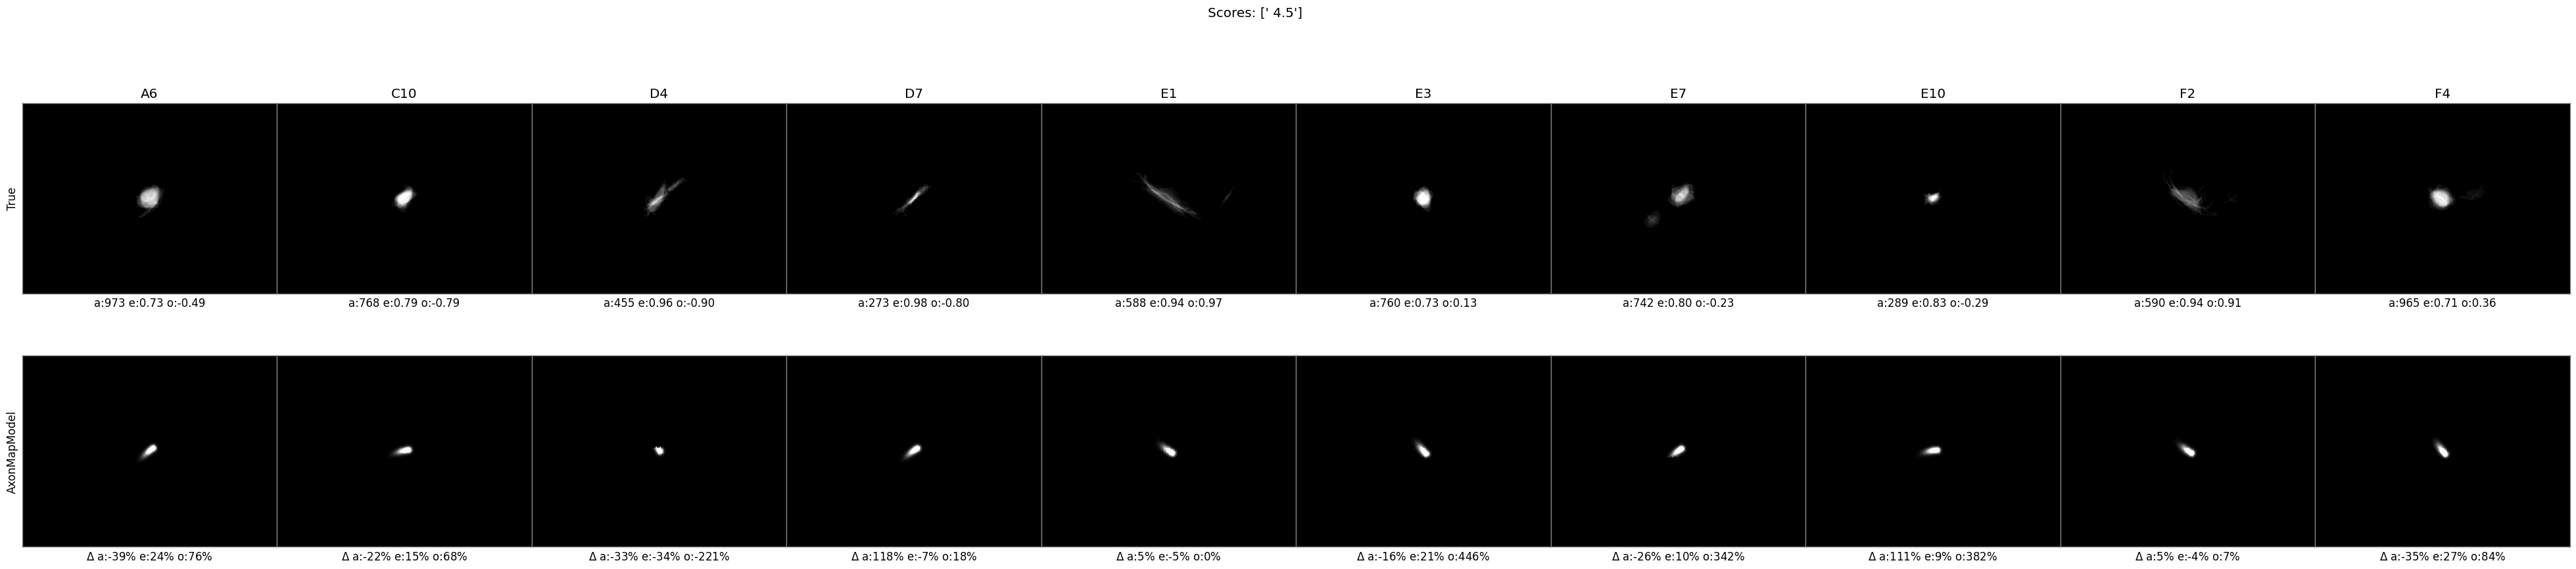

In [94]:
res = beyeler2019_eval(subject, implant, model)
print(res.results)
plot_beyeler_percepts(res)

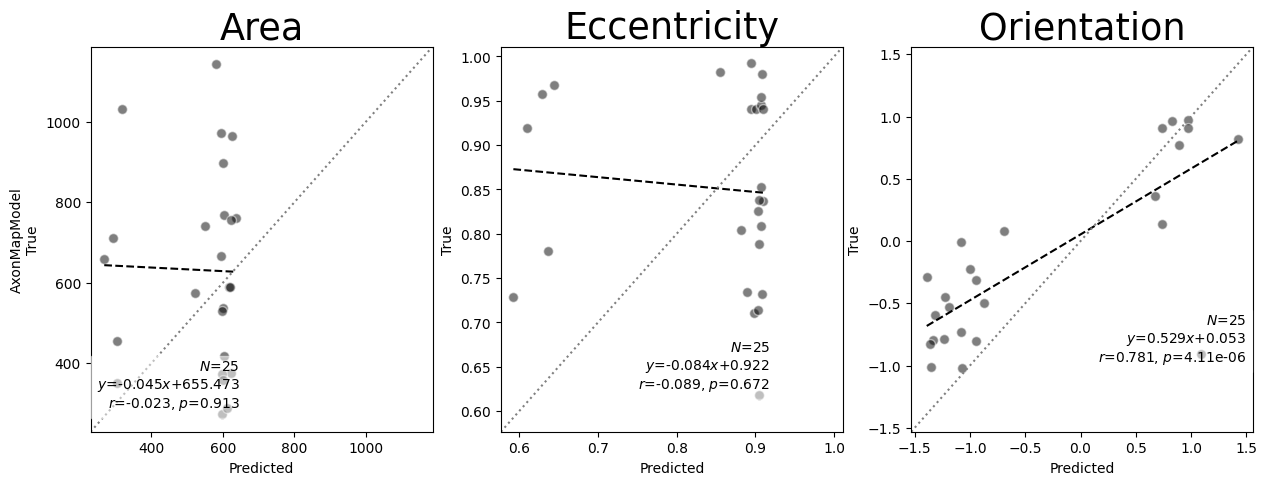

In [6]:
plot_beyeler_props(res)

In [112]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
model.rho = 100
model.axlambda = 585
model.build()
res = beyeler2019_eval(subject, implant, model)
print(res.results)

{'beyeler2019': {'score': 2.781201958656311, 'r2_scores': array([-0.669, -1.497,  0.385]), 'time': 0.21671247482299805}}


In [113]:
from scipy.optimize import minimize, differential_evolution

In [6]:

def opt_fn(params, subject='12-005'):
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    model.rho = params[0]
    model.axlambda = params[1]
    model.build()
    res = beyeler2019_eval(subject, implant, model, data=data)
    print(f"{res.results['beyeler2019']['score'] : .3f}")
    return res.results['beyeler2019']['score']

In [22]:
opt = minimize(opt_fn, [100, 585])

1.6189283461406982
1.6189283461406982
1.6189283461406982


In [24]:
opt

      fun: 1.6189283461406982
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([100., 585.])

In [16]:
def cb(xk, convergence=0.0):
    print(xk, convergence)

In [114]:
opts = []
for subject in ['12-005', '52-001', '51-009']:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    def opt_fn(params):
        implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
        model.rho = params[0]
        model.axlambda = params[1]
        model.build()
        res = beyeler2019_eval(subject, implant, model, data=data)
        print(f"{res.results['beyeler2019']['score'] : .3f}")
        return res.results['beyeler2019']['score']
    opt = differential_evolution(opt_fn, [(20, 600), (25, 2000)], x0=[100, 585])
    opts.append(opt)
    print('---------------------------------------------------')

 2.781
 21.328
 350.469
 33.898
 64.829
 50.804
 711.469
 68.328
 4.828
 2.961
 4.812
 742.461
 627.223
 25.416
 169.398
 382.888
 83.475
 3.936
 90.647
 1000.599
 4.447
 972.098
 288.768
 4.055
 72.844
 367.337
 21.005
 572.933
 36.947
 19.603
 3.060
 99.405
 6.286
 71.993
 3.583
 2.947
 11.412
 23.106
 105.789
 4.139
 6.021
 420.661
 15.788
 53.112
 9.524
 86.696
 11.578
 55.632
 117.338
 10.643
 40.744
 684.404
 5.439
 287.872
 3.712
 40.421
 3.515
 22.857
 3.070
 2.756
 11.911
 173.568
 23.956
 6.327
 6.678
 40.435
 3.306
 6.681
 9.324
 17.346
 50.439
 7.568
 106.788
 14.149
 9.588
 4.032
 34.523
 72.050
 5.201
 27.530
 15.236
 3.008
 3.338
 6.533
 9.230
 38.344
 5.804
 3.957
 6.121
 3.375
 3.471
 86.270
 3.638
 23.230
 10.590
 4.679
 13.188
 2.923
 4.164
 5.669
 3.339
 162.255
 18.843
 3.199
 4.418
 2.562
 4.501
 13.774
 7.659
 3.977
 3.636
 3.106
 4.807
 3.725
 7.834
 2.626
 4.228
 18.243
 2.737
 2.790
 2.509
 2.983
 38.815
 3.039
 24.483
 4.164
 3.969
 2.741
 3.727
 8.610
 2.977

In [120]:
for i, opt in enumerate(opts):
    print(['12-005', '52-001', '51-009'][i])
    print(opt)

12-005
 message: Optimization terminated successfully.
 success: True
     fun: 2.427251875400543
       x: [ 1.218e+02  4.614e+02]
     nit: 12
    nfev: 393
52-001
 message: Optimization terminated successfully.
 success: True
     fun: 1.1469376683235168
       x: [ 1.575e+02  1.355e+03]
     nit: 14
    nfev: 453
51-009
 message: Optimization terminated successfully.
 success: True
     fun: 7.70695024728775
       x: [ 2.226e+01  9.008e+02]
     nit: 16
    nfev: 513


### Eval using all data

In [6]:
for subject in ['12-005', '52-001', '51-009']:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False)
    model.build()
    res = beyeler2019_eval(subject, implant, model, data=data, test_amps=None)
    print((subject, model.rho, model.axlambda))
    print(res.results)

(120, 446)
{'beyeler2019': {'score': 1.763188548058004, 'r2_scores': array([-0.57, -1.47, -0.79]), 'time': 0.18421578407287598}}
(158, 1250)
{'beyeler2019': {'score': 1.3120534961657577, 'r2_scores': array([ 0.12, -0.33, -0.5 ]), 'time': 0.3957254886627197}}
(22, 882)
{'beyeler2019': {'score': 2.9631100927224616, 'r2_scores': array([ 2.07e-03, -1.57e+01, -6.22e-01]), 'time': 0.40395545959472656}}


## Multivariate Gaussian Model

In [7]:
from pulse2percept.models import MVGModel
matplotlib.rcParams.update({'font.size': 12})

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

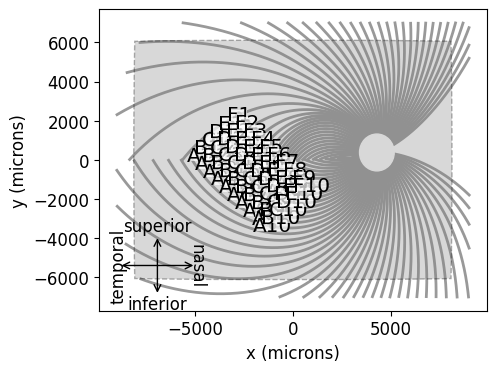

In [20]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel())
model.axlambda = 0.95
model.build()
model.plot(figsize=(5, 5))
implant.plot(annotate=True)

### Verify props line up

In [8]:
subject = '12-005'
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel())
model.rho = 500
model.axlambda = 0.8
model.build()

MVGModel(ax_segments_range=(0, 50), axlambda=461, 
         axon_pickle='axons.pickle', 
         axons_range=(-180, 180), engine=None, eta=0.8, 
         eye='RE', grid_type='rectangular', 
         ignore_pickle=False, loc_od=(15.8, 1.4), 
         min_ax_sensitivity=0.001, n_ax_segments=500, 
         n_axons=1000, n_gray=None, n_jobs=1, n_threads=24, 
         noise=None, orient_scale=1, 
         retinotopy=Watson2014Map, rho=500, 
         scheduler='threading', spatial=MVGSpatial, 
         temporal=None, thresh_percept=0.1353352832366127, 
         verbose=True, xrange=(-30, 30), xystep=0.25, 
         yrange=(-22.5, 22.5))

Bundle Tangent: [-1.398]
[499.0, 0.8002521066014681, -1.4043713930056498]


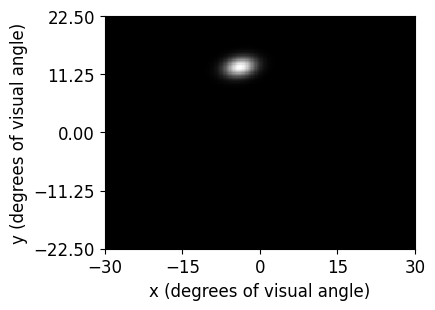

In [9]:
elec = 'A10'
print(f"Bundle Tangent: {model.calc_bundle_tangent_fast(implant.electrodes[elec].x, implant.electrodes[elec].y) - np.pi/2}")
implant.stim = {'A10' : 1}
p = model.predict_percept(implant)
p.plot(figsize=(4, 4))
props = measure.regionprops(measure.label(p.max(axis='frames') > 1 / np.exp(1)**2))
prop = max(props, key = lambda x : x.area)
print([prop.area, prop.eccentricity, prop.orientation])

### Optimize

In [7]:
def get_mvg_fit(subject, model, data=None):

    areas = []
    eccs = []
    img_shape = None
    if data is None:
        data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    data = data[data.subject == subject]
    data = data[data.amp1.isin([2.])]
    for elec in data.electrode1.unique():
        dfelec = data[data.electrode1 == elec]
        ars = []
        ecs = []
        for img in dfelec.image:
            if img_shape is None:
                img_shape = img.shape
            # im = resize(img, model.grid.shape)
            try:
                prop = max(measure.regionprops(measure.label(img > 1 / np.exp(1)**2)), key = lambda x : x.area)
                ars.append(prop.area)
                ecs.append(prop.eccentricity)
            except:
                ars.append(0)
                ecs.append(0.25)
                print(elec)
        areas.append(np.mean(ars))
        eccs.append(np.mean(ecs))
    return np.mean(areas) / ( img_shape[0]*img_shape[1] / (model.grid.shape[0]*model.grid.shape[1])), np.mean(eccs)

### Optimize (scipy)

In [14]:
from scipy.optimize import differential_evolution
def opt_fn(params, subject='12-005'):
    model = MVGModel()
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=model)
    model.rho = params[0]
    model.axlambda = params[1]
    model.build()
    res = beyeler2019_eval(subject, implant, model, data=data)
    print(f"{res.results['beyeler2019']['score'] : .3f}")
    return res.results['beyeler2019']['score']

In [17]:
opts = []
for subject in ['12-005', '52-001', '51-009']:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    def opt_fn(params, subject='12-005'):
        model = MVGModel()
        implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=model)
        model.rho = params[0]
        model.axlambda = params[1]
        model.build()
        res = beyeler2019_eval(subject, implant, model, data=data)
        print(f"{model.rho :.1f}, {model.axlambda :.3f}, {res.results['beyeler2019']['score'] : .3f}")
        return res.results['beyeler2019']['score']
    opt = differential_evolution(opt_fn, [(20, 1000), (0, 1)], x0=[data.area.mean(), data.eccentricity.mean()])
    opts.append(opt)
    print('---------------------------------------------------')

560.2, 0.868,  4.195
410.0, 0.509,  3.684
193.5, 0.212,  3.729
944.3, 0.593,  5.482
507.1, 0.834,  3.939
714.6, 0.375,  4.952
862.4, 0.818,  5.246
317.8, 0.016,  4.228
667.0, 0.135,  5.005
100.8, 0.461,  2.871
929.8, 0.412,  5.495
890.5, 0.979,  5.332
35.2, 0.249,  3.724
58.2, 0.186,  3.795
828.7, 0.600,  5.184
683.7, 0.870,  4.690
764.0, 0.748,  4.965
530.7, 0.950,  4.073
354.5, 0.909,  2.988
605.6, 0.681,  4.422
573.3, 0.545,  4.366
257.3, 0.053,  4.140
798.4, 0.081,  5.356
132.0, 0.471,  2.792
471.5, 0.361,  4.160
229.9, 0.116,  4.002
438.6, 0.796,  3.563
632.1, 0.706,  4.517
286.8, 0.329,  3.570
182.0, 0.647,  2.010
43.7, 0.245,  3.751
103.6, 0.793,  1.331
193.5, 0.107,  3.957
291.2, 0.593,  2.852
338.1, 0.834,  2.841
780.5, 0.438,  5.107
862.4, 0.581,  5.279
360.6, 0.691,  3.128
742.3, 0.208,  5.135
394.1, 0.837,  3.264
77.5, 0.624,  2.238
75.4, 0.868,  1.477
184.6, 0.759,  1.508
58.2, 0.912,  1.705
602.8, 0.540,  4.482
197.8, 0.870,  1.436
112.6, 0.456,  2.842
58.0, 0.668,  2.163

ValueError: Some entries in x0 lay outside the specified bounds

### Extensions (e.g. modulate area/orient with angle/ecc)

#### Baseline (orient_scale=1)

('12-005', 140.0813145582411, 0.8517459020804675)
{'beyeler2019': {'score': 0.6479016542434692, 'r2_scores': array([ 0.01, -0.  ,  0.35]), 'time': 2.2997326850891113}}
---------------
('52-001', 387.4343547369439, 0.8473408689708681)
{'beyeler2019': {'score': 0.8212776780128479, 'r2_scores': array([3.42e-05, 1.50e-03, 1.77e-01]), 'time': 2.717135429382324}}
---------------
('51-009', 40.93923322082264, 0.9846336405699808)
{'beyeler2019': {'score': 1.523102879524231, 'r2_scores': array([-0.03, -0.04, -0.45]), 'time': 2.6487905979156494}}
---------------


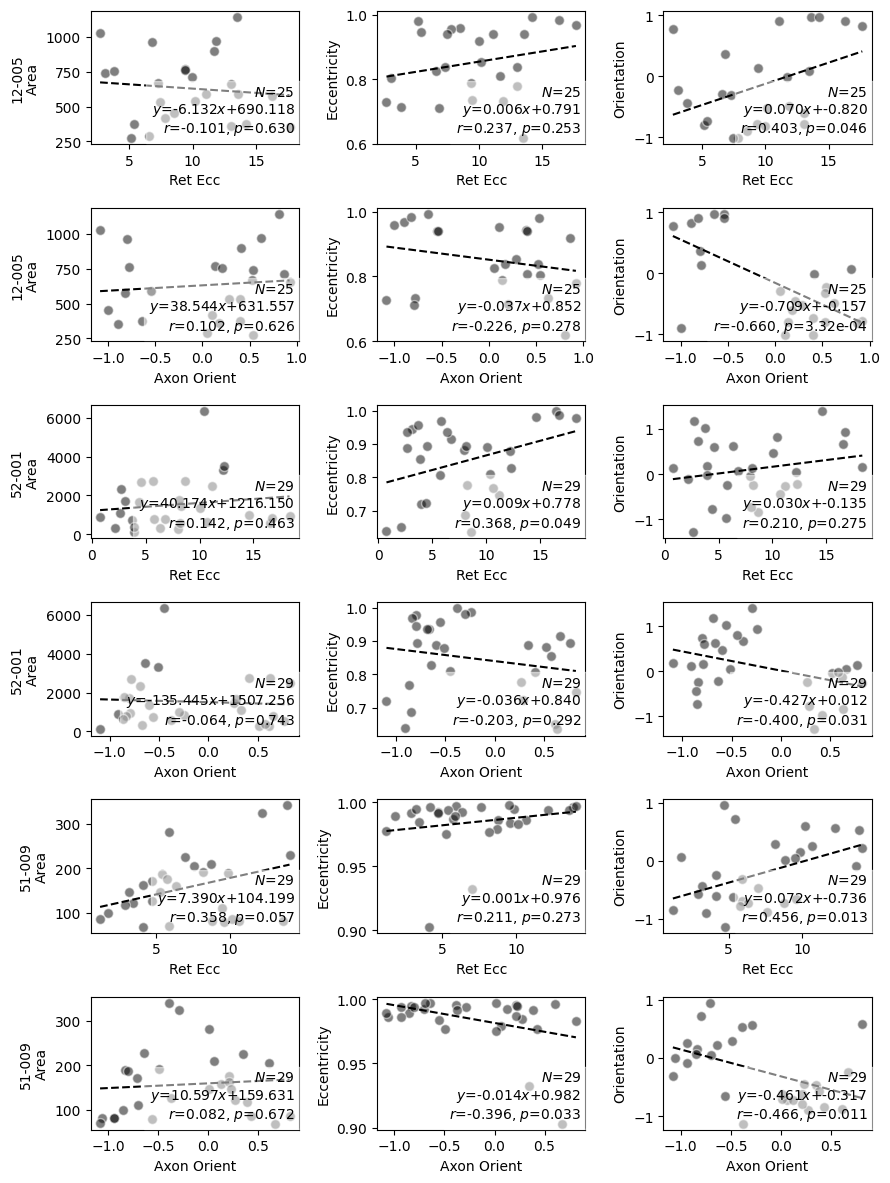

In [13]:
subjects = ['12-005', '52-001', '51-009']
results = []
for subject in subjects:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel(orient_scale=1))
    model.build()
    model.rho, model.axlambda = get_mvg_fit(subject, model, data=data)
    model.build()
    print((subject, model.rho, model.axlambda))
    res = beyeler2019_eval(subject, implant, model)
    print(res.results)
    results.append(res)
    print('---------------')
    
plot_beyeler_ext(results, names=subjects)

('12-005', 140.0813145582411, 0.8517459020804675)
{'beyeler2019': {'score': 0.28823143243789673, 'r2_scores': array([0.  , 0.  , 0.71]), 'time': 2.3172168731689453}}
---------------
('52-001', 387.4343547369439, 0.8473408689708681)
{'beyeler2019': {'score': 0.3836398422718048, 'r2_scores': array([-6.48e-05,  9.36e-04,  6.15e-01]), 'time': 2.745234251022339}}
---------------
('51-009', 40.93923322082264, 0.9846336405699808)
{'beyeler2019': {'score': 0.5388379991054535, 'r2_scores': array([-0.02, -0.08,  0.57]), 'time': 2.668051242828369}}
---------------


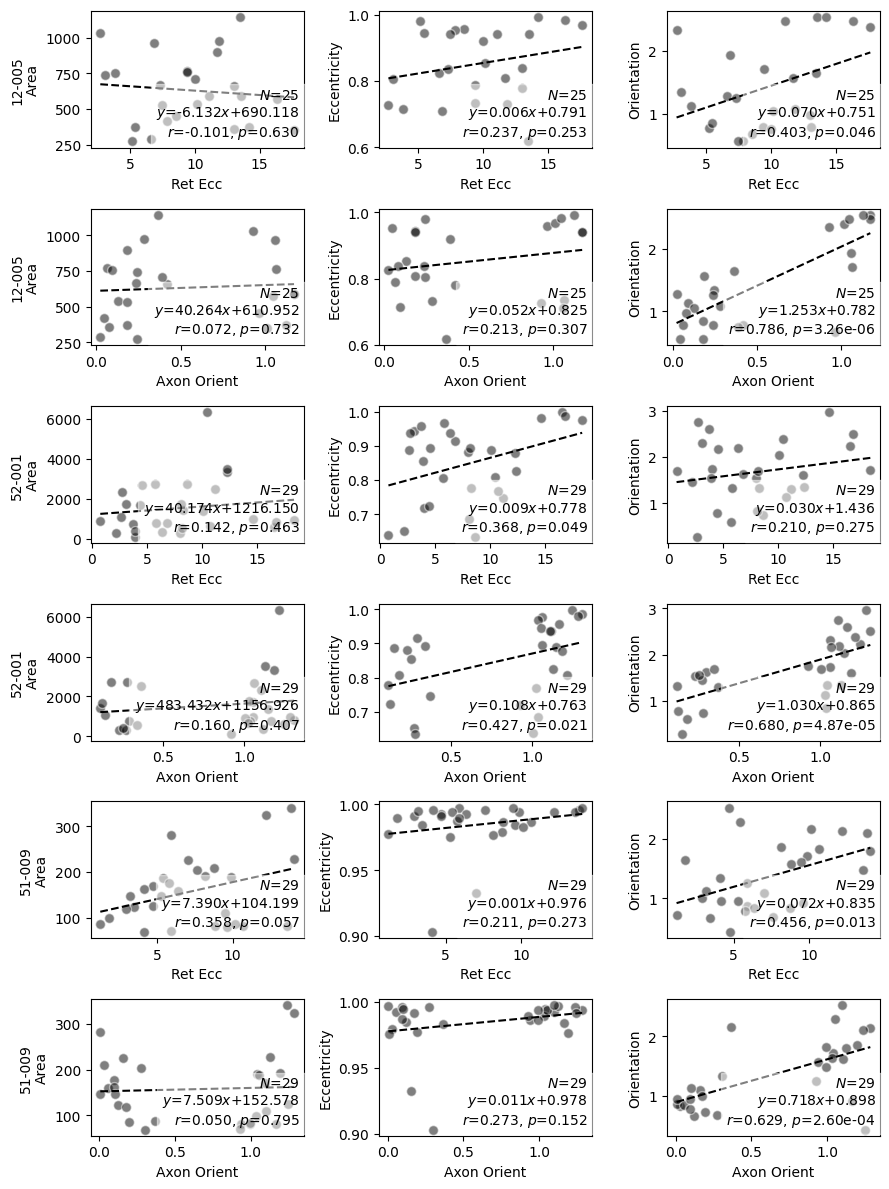

In [10]:
# NEW post hoc adjusted
subjects = ['12-005', '52-001', '51-009']
results = []
for subject in subjects:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel(orient_scale=np.mean(scales)))
    model.build()
    model.rho, model.axlambda = get_mvg_fit(subject, model, data=data)
    model.build()
    print((subject, model.rho, model.axlambda))
    res = beyeler2019_eval(subject, implant, model)
    print(res.results)
    results.append(res)
    print('---------------')
    
plot_beyeler_ext(results, names=subjects)

In [11]:
np.mean(scales)

0.4503333333333333

In [8]:
scales = [0.564, 0.464, 0.323]
ints = [0.751, 0.865, 0.898]

In [17]:
np.mean(ints)

0.8380000000000001

In [13]:
[scal / np.pi/2 for scal in scales]

[0.08976338790382897, 0.07384789359463945, 0.051407046618682194]

0.7282525897026062


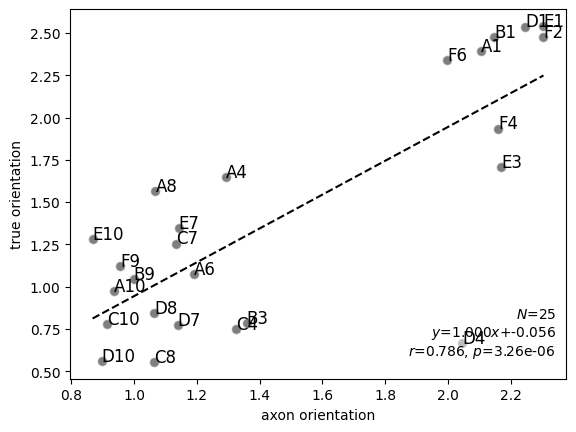

In [16]:
x = (results[0].data['beyeler2019']['preds']['axon_orient'])
x = x * 0.564 + np.mean(ints)
y = results[0].data['beyeler2019']['true']['props'][:, 2] + np.pi/2
yp = results[0].data['beyeler2019']['preds']['props'][:, 2]
scatter_correlation(x, y, show_slope_intercept=True)
for i, elec in enumerate(results[0].data['beyeler2019']['elecs']):
    plt.annotate(elec, (x[i], y[i]))
plt.xlabel('axon orientation')
plt.ylabel('true orientation')
print(circ_r2_score(y, x))

#### Improve

('12-005', 140.0813145582411, 0.8517459020804675)
{'beyeler2019': {'score': 1.6623191237449646, 'r2_scores': array([ 1.69e-04,  1.04e-02, -6.73e-01]), 'time': 2.295701503753662}}
---------------
('52-001', 387.4343547369439, 0.8473408689708681)
{'beyeler2019': {'score': 2.4048070907592773, 'r2_scores': array([-3.63e-04, -2.93e-03, -1.40e+00]), 'time': 2.755495071411133}}
---------------
('51-009', 40.93923322082264, 0.9846336405699808)
{'beyeler2019': {'score': 1.8032580614089966, 'r2_scores': array([-0.04, -0.07, -0.69]), 'time': 2.6705503463745117}}
---------------


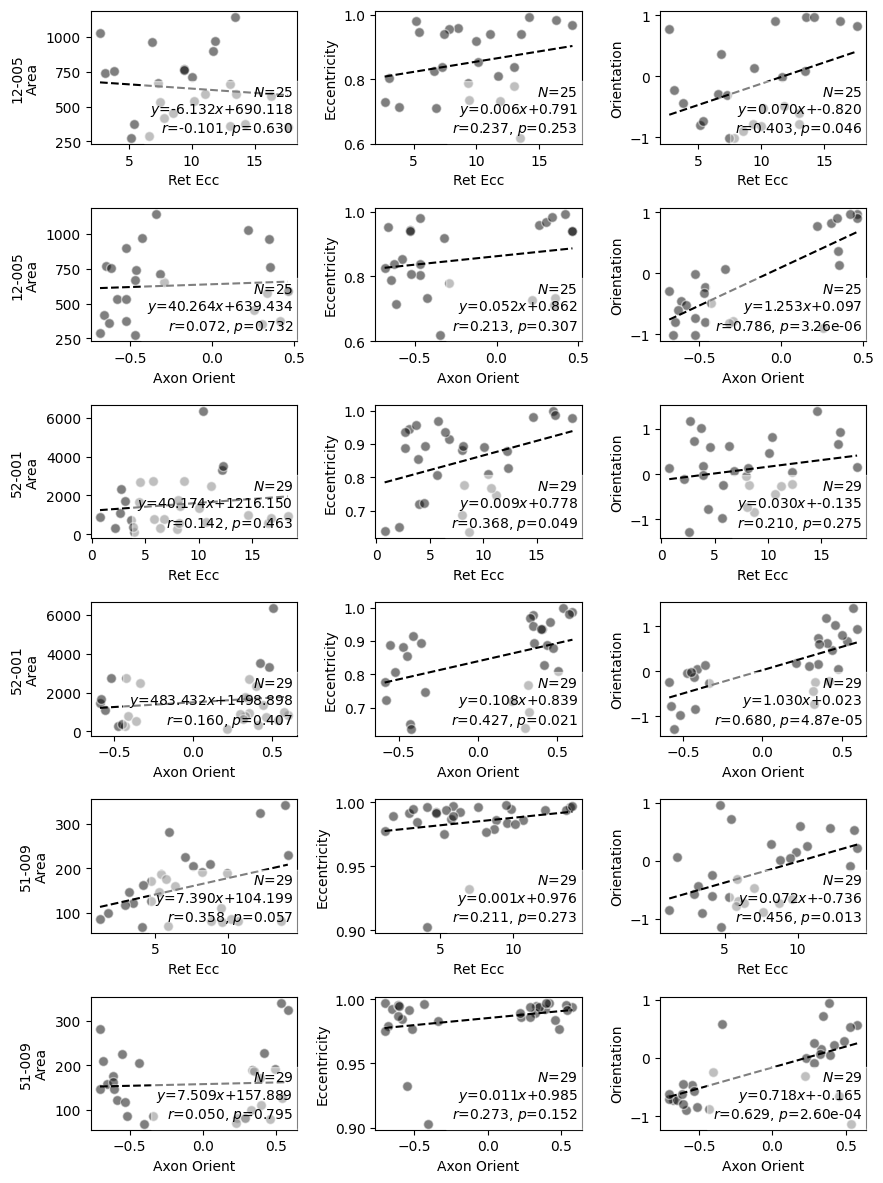

In [10]:
### AVERAGE SCALE ORIENT
subjects = ['12-005', '52-001', '51-009']
results = []
for subject in subjects:
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel())
    model.build()
    model.rho, model.axlambda = get_mvg_fit(subject, model, data=data)
    model.orient_scale = np.mean([0.323, 0.464, 0.564])
    model.build()
    print((subject, model.rho, model.axlambda))
    res = beyeler2019_eval(subject, implant, model)
    print(res.results)
    results.append(res)
    print('---------------')
    
plot_beyeler_ext(results, names=subjects)

('12-005', 140.0813145582411, 0.8517459020804675)
{'beyeler2019': {'score': 0.30244889855384827, 'r2_scores': array([-0.01, -0.01,  0.72]), 'time': 2.2942845821380615}}
---------------
('52-001', 387.4343547369439, 0.8473408689708681)
{'beyeler2019': {'score': 0.37708717584609985, 'r2_scores': array([-4.73e-05,  2.81e-03,  6.20e-01]), 'time': 2.7159180641174316}}
---------------
('51-009', 40.93923322082264, 0.9846336405699808)
{'beyeler2019': {'score': 0.5148970484733582, 'r2_scores': array([-0.03, -0.06,  0.57]), 'time': 2.646712064743042}}
---------------


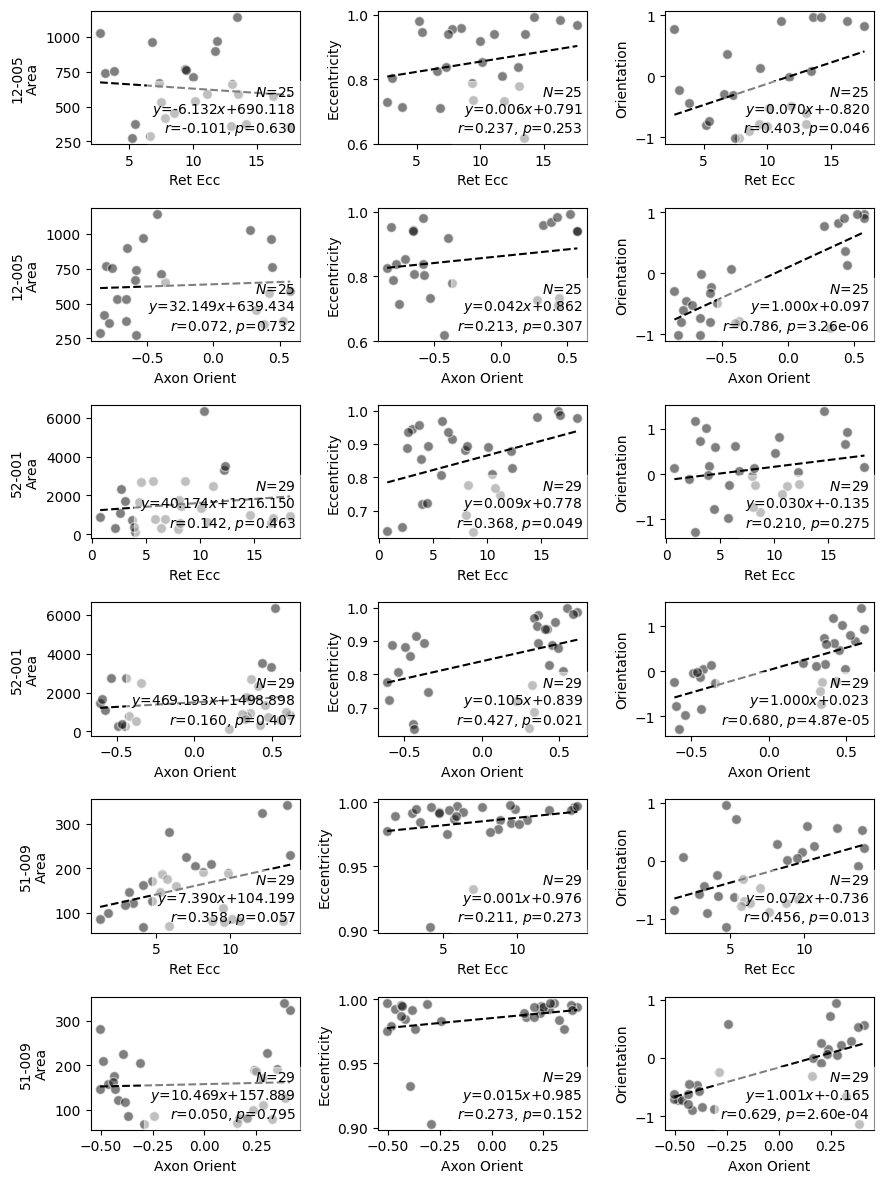

In [13]:
### specific SCALE ORIENT
subjects = ['12-005', '52-001', '51-009']
results = []
ors = [0.323, 0.464, 0.564][::-1]
for i, subject in enumerate(subjects):
    data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
    implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel())
    model.build()
    model.rho, model.axlambda = get_mvg_fit(subject, model, data=data)
    model.orient_scale = ors[i]
    model.build()
    print((subject, model.rho, model.axlambda))
    res = beyeler2019_eval(subject, implant, model)
    print(res.results)
    results.append(res)
    print('---------------')
    
plot_beyeler_ext(results, names=subjects)

{'beyeler2019': {'score': 0.6480121612548828, 'r2_scores': array([ 0.01, -0.  ,  0.35]), 'time': 2.2757019996643066}}


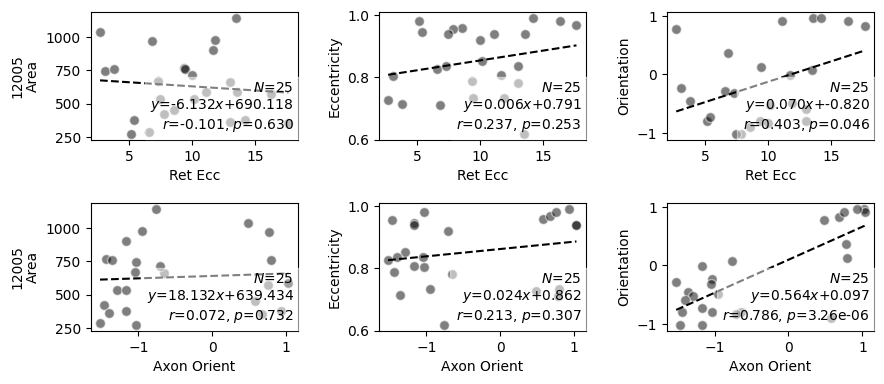

In [8]:
# Test with 12005
subject = '12-005'
data = shapes.load_shapes(h5_shapes, stim_class='SingleElectrode', subjects=[subject])
implant, model = shapes.model_from_params(shapes.subject_params[subject], biphasic=False, model=MVGModel())
model.build()
model.rho, model.axlambda = get_mvg_fit(subject, model, data=data)
res = beyeler2019_eval(subject, implant, model)
print(res.results)
plot_beyeler_ext(res, names=['12005'])

{'beyeler2019': {'score': 0.30244889855384827, 'r2_scores': array([-0.01, -0.01,  0.72]), 'time': 2.4071736335754395}}


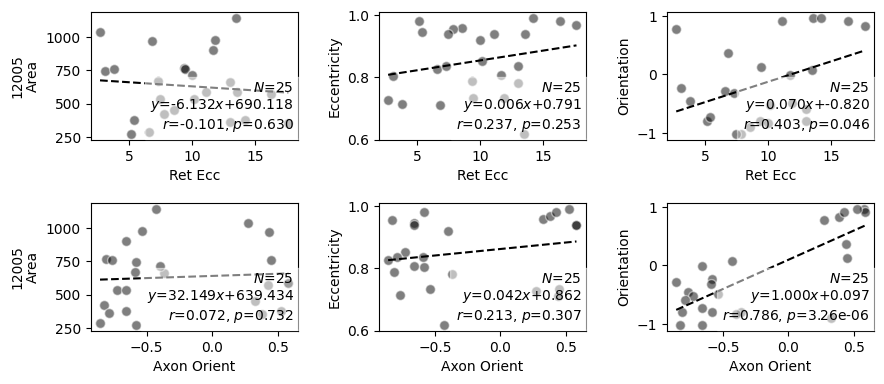

In [9]:
# test with 12005
model.orient_scale = 0.564
res = beyeler2019_eval(subject, implant, model)
print(res.results)
plot_beyeler_ext(res, names=['12005'])

# Granley

## Biphasic, Axon Map, and Nanduri

Note that this biphasic axon map is not fit to this data (fit to shapes data), so results don't match embc 

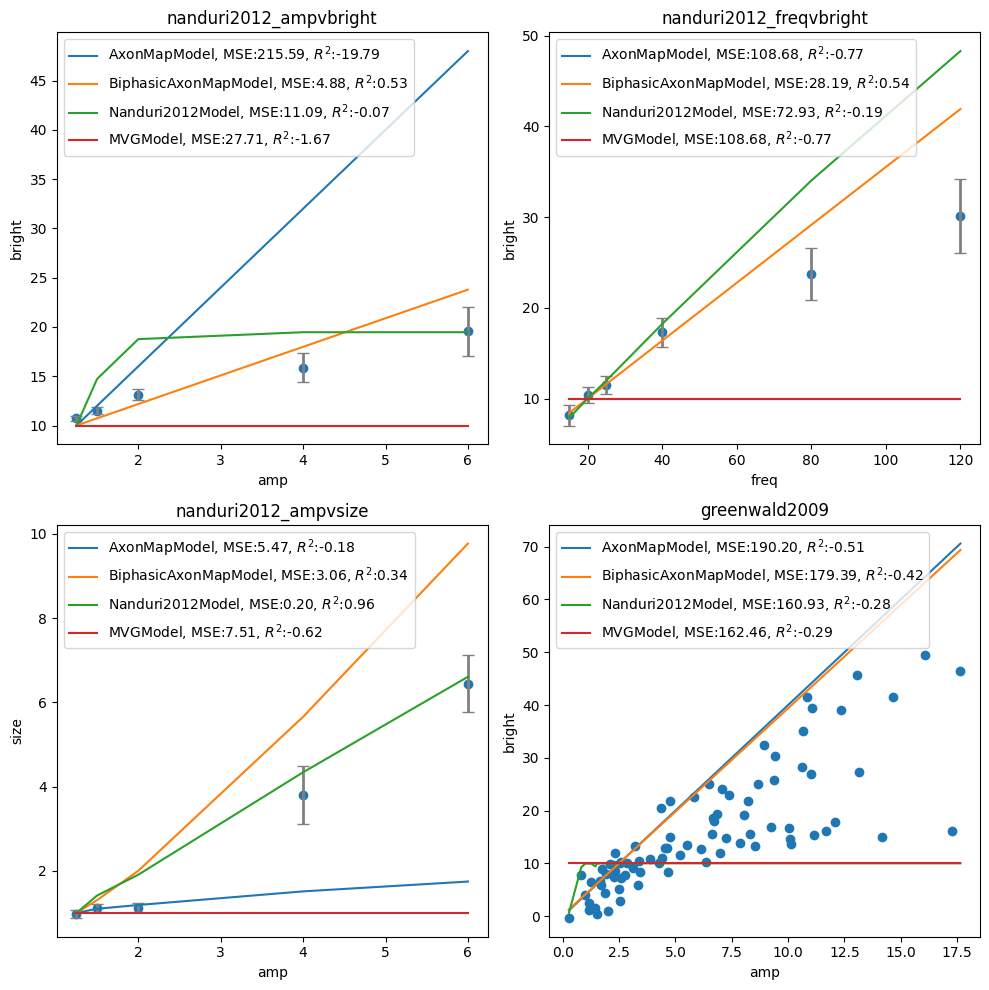

In [9]:
from pulse2percept.models import MVGModel
matplotlib.rcParams.update({'font.size': 10})
models = [AxonMapModel(), BiphasicAxonMapModel(), MVGModel(rho=200, axlambda=0.85)]
results = []
for model in models:
    results.append(granley2021_eval(model))
plot_granley(results)

## MVG Model 

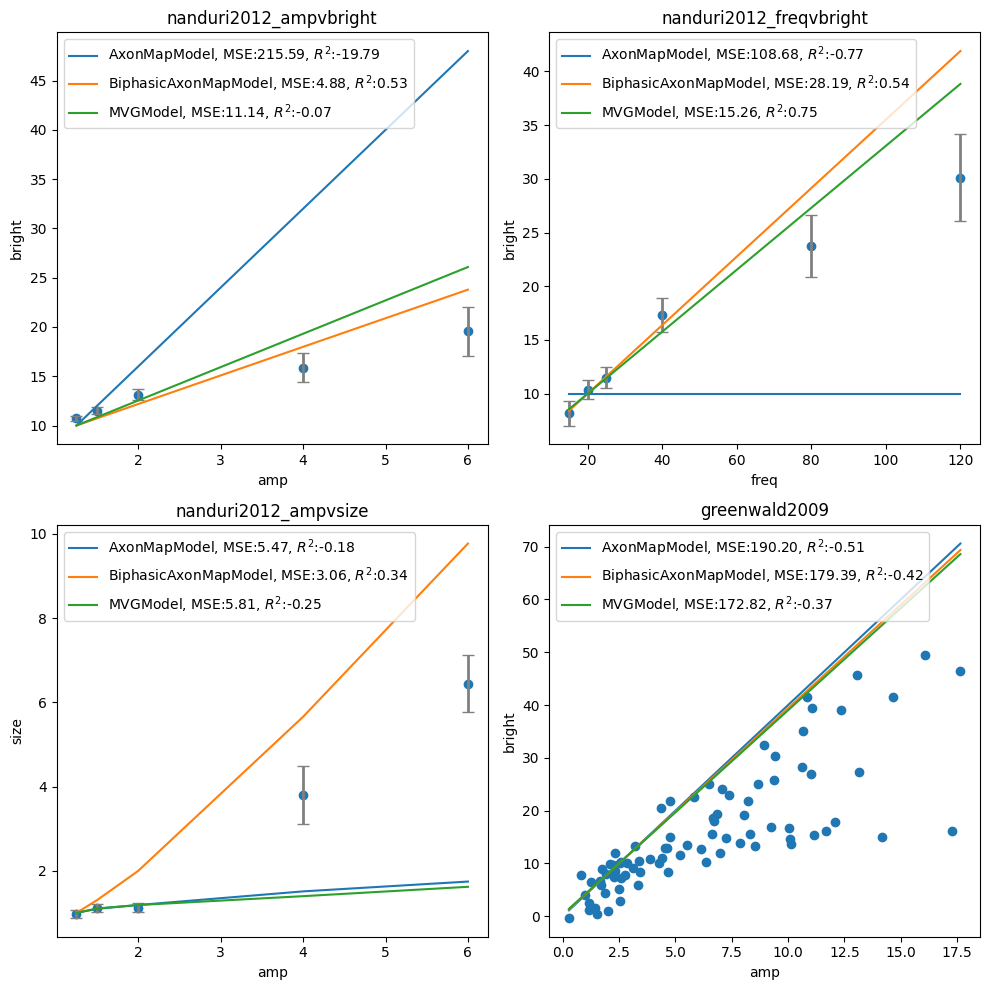

In [5]:
# Same as axon map params
from pulse2percept.models import MVGModel
matplotlib.rcParams.update({'font.size': 10})
models = [AxonMapModel(), BiphasicAxonMapModel(), MVGModel(rho=200, axlambda=0.85)]
results = []
for model in models:
    results.append(granley2021_eval(model))
plot_granley(results)

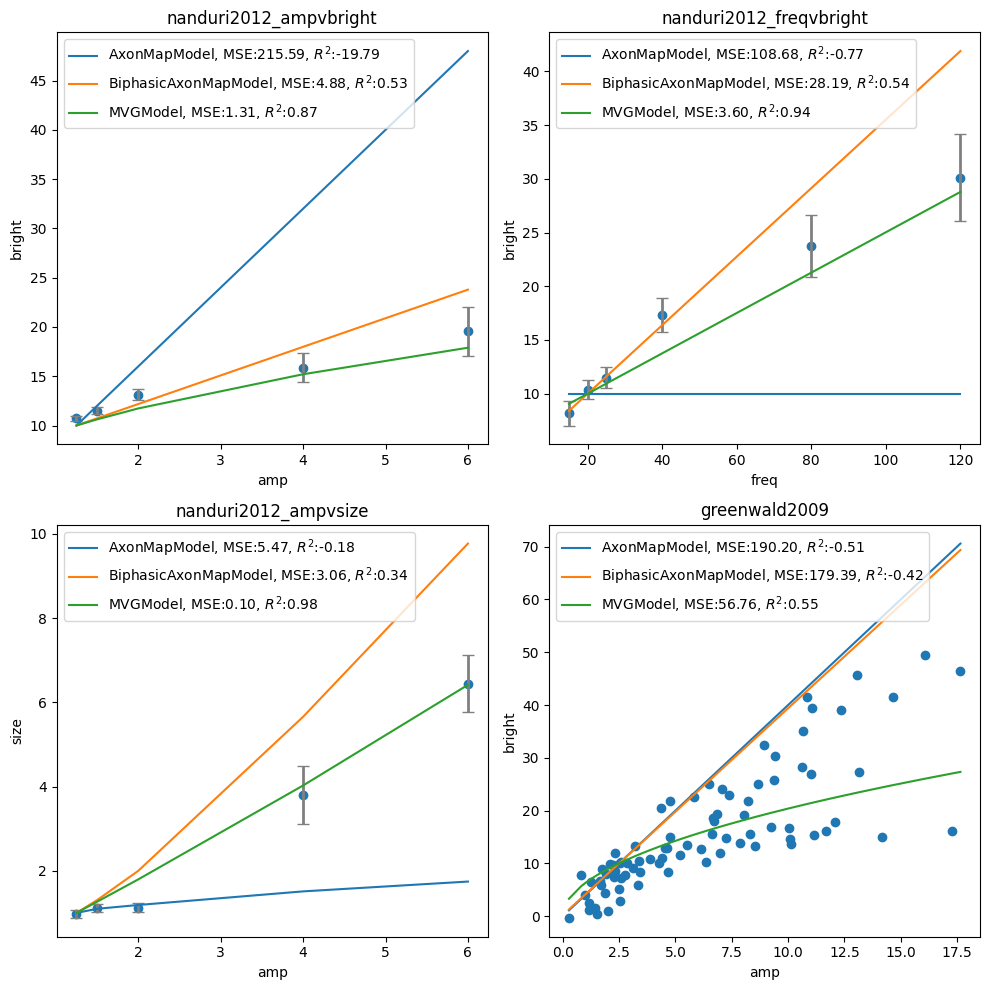

In [5]:
models = [AxonMapModel(), BiphasicAxonMapModel(), MVGModel(rho=200, axlambda=0.85)]
results = [granley2021_eval(model) for model in models]
plot_granley(results)

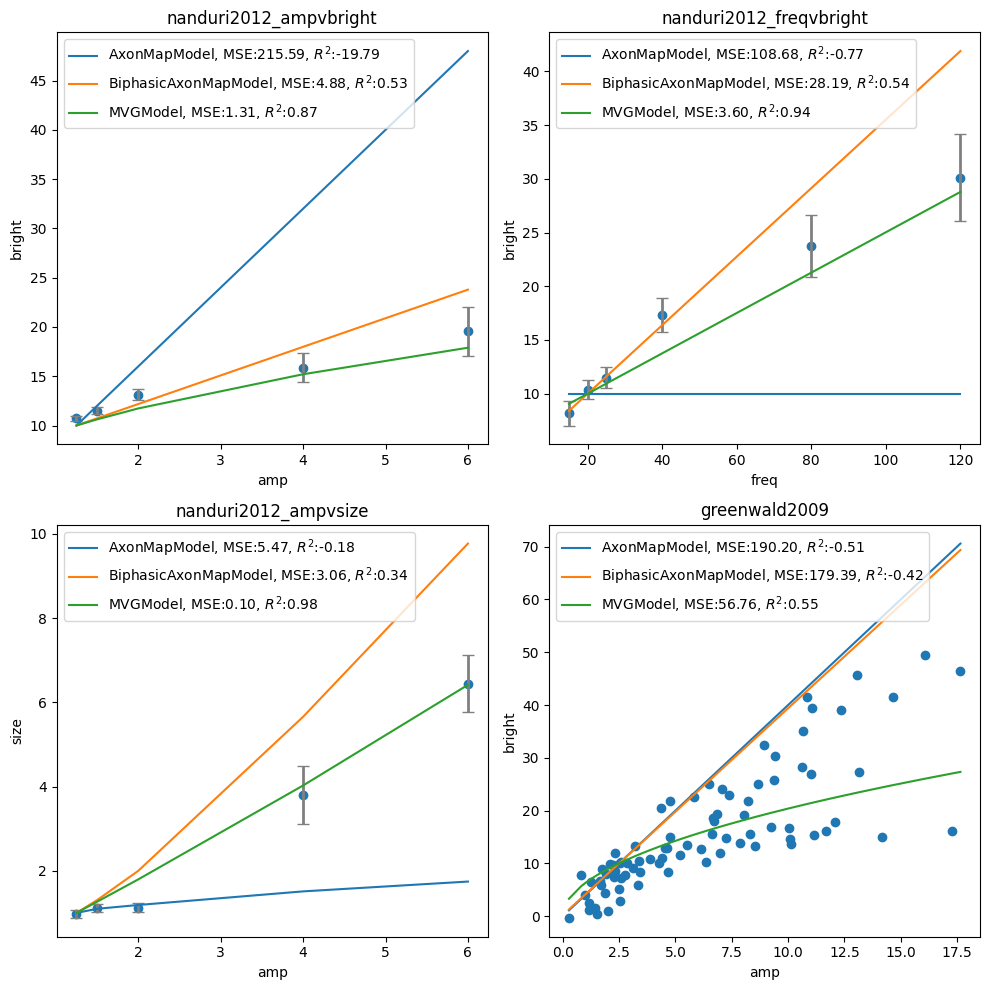

In [6]:
models = [AxonMapModel(), BiphasicAxonMapModel(), MVGModel(rho=200, axlambda=0.85)]
results = [granley2021_eval(model) for model in models]
plot_granley(results)

### Fitting parameters

#### Bright

(5, 2)
0.14203431818481863
0.7159313636303625
12.480057758933615


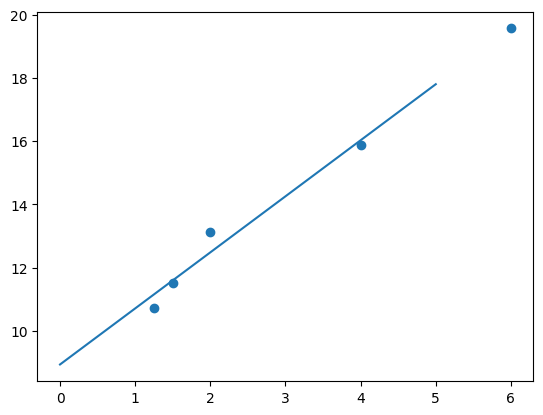

In [40]:
data = load_nanduri2012(task='rate')
data = data[data['varied_param'] == 'amp']
data = data.groupby(['amp_factor'])['brightness'].mean().reset_index()
plt.scatter(data.amp_factor, data.brightness)
print(data.shape)
x = data[['amp_factor']]
y = data['brightness']
afmodel = LinearRegression(fit_intercept=True)
afmodel.fit(x, y)
scal = afmodel.predict(np.array([2]).reshape((1, -1)))[0]
y = y / scal
afmodel.fit(x, y)
print(afmodel.coef_[0])
print(afmodel.intercept_)
print(scal)
xs = [i for i in range(6)]
ys = [afmodel.coef_[0] * i * scal + afmodel.intercept_ * scal for i in xs]
plt.plot(xs, ys)

In [42]:
0.71 / 20

0.0355

(array([0.47, 0.52, 0.02]), array([[ 6.65e-03, -8.23e-03, -9.17e-05],
       [-8.23e-03,  1.40e-02,  9.54e-05],
       [-9.17e-05,  9.54e-05,  2.28e-06]]))
[0.47336219290162224, 0.521075541786307, 0.016035677570719612]


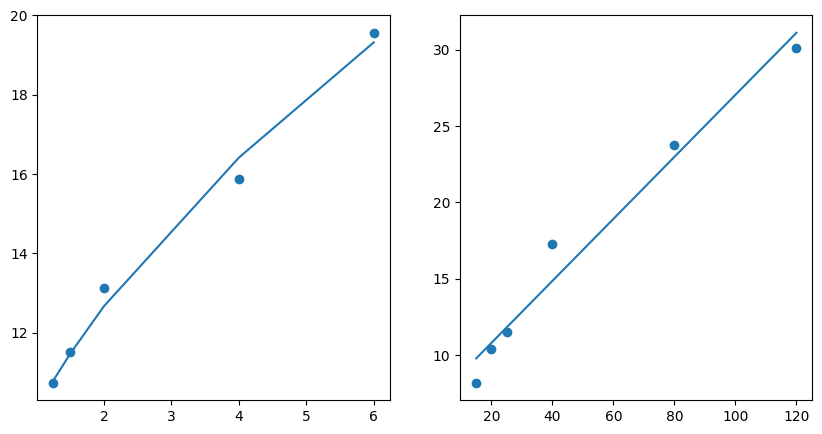

In [70]:
from pulse2percept.datasets import load_nanduri2012
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import numpy as np
data = load_nanduri2012()
data = data[data['task'] == 'rate']
# data = data.groupby(['amp_factor', 'freq'])['brightness'].mean().reset_index()
x = np.array(data[['amp_factor', 'freq']])
y = np.array(data['brightness'])

def fn(x, a, b, c):
    x0 = x[:, 0]
    x1 = x[:, 1]
    return a*x0**b + c*x1
fit = curve_fit(fn, x, y)
scal = fn(np.array([[2, 20]]), *fit[0])
y_scaled = y / scal
fit = curve_fit(fn, x, y_scaled)
print(fit)
print(list(fit[0]))
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

plt.sca(axes[0])
xs = data[data['varied_param'] == 'amp'].amp_factor.unique()
ys = data[data['varied_param'] == 'amp'].groupby(['amp_factor'])['brightness'].mean()
sems = data[data['varied_param'] == 'amp'].groupby(['amp_factor'])['brightness'].std()
plt.scatter(xs, ys)
plt.plot(xs, [scal * fn(np.array([[xi, 20]]), *fit[0]) for xi in xs])

plt.sca(axes[1])
xs = data[data['varied_param'] == 'freq'].freq.unique()
ys = data[data['varied_param'] == 'freq'].groupby(['freq'])['brightness'].mean()
sems = data[data['varied_param'] == 'freq'].groupby(['freq'])['brightness'].std()
plt.scatter(xs, ys)
plt.plot(xs, [scal * fn(np.array([[1.25, xi]]), *fit[0]) for xi in xs])

(array([0.27, 0.02]), array([[ 7.26e-04, -1.90e-05],
       [-1.90e-05,  1.96e-06]]))


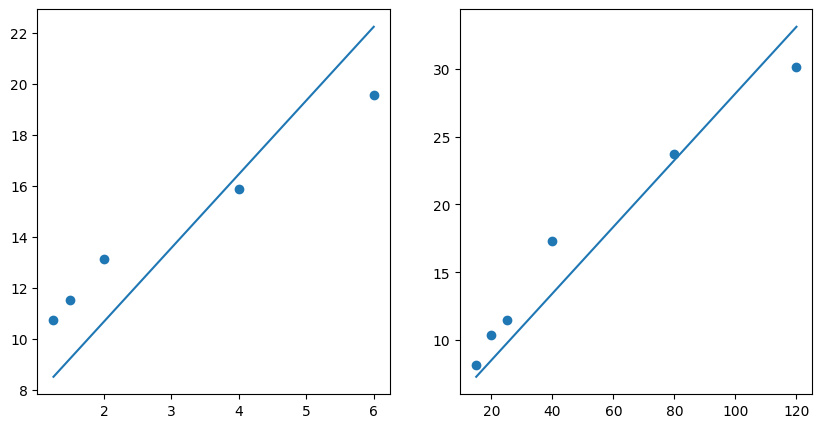

In [69]:
from pulse2percept.datasets import load_nanduri2012
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import numpy as np
data = load_nanduri2012()
data = data[data['task'] == 'rate']
# data = data.groupby(['amp_factor', 'freq'])['brightness'].mean().reset_index()
x = np.array(data[['amp_factor', 'freq']])
y = np.array(data['brightness'])

def fn(x, a, c):
    x0 = x[:, 0]
    x1 = x[:, 1]
    return a*x0 + c*x1
fit = curve_fit(fn, x, y)
scal = fn(np.array([[2, 20]]), *fit[0])
y_scaled = y / scal
fit = curve_fit(fn, x, y_scaled)
print(fit)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

plt.sca(axes[0])
xs = data[data['varied_param'] == 'amp'].amp_factor.unique()
ys = data[data['varied_param'] == 'amp'].groupby(['amp_factor'])['brightness'].mean()
sems = data[data['varied_param'] == 'amp'].groupby(['amp_factor'])['brightness'].std()
plt.scatter(xs, ys)
plt.plot(xs, [scal * fn(np.array([[xi, 20]]), *fit[0]) for xi in xs])

plt.sca(axes[1])
xs = data[data['varied_param'] == 'freq'].freq.unique()
ys = data[data['varied_param'] == 'freq'].groupby(['freq'])['brightness'].mean()
sems = data[data['varied_param'] == 'freq'].groupby(['freq'])['brightness'].std()
plt.scatter(xs, ys)
plt.plot(xs, [scal * fn(np.array([[1.25, xi]]), *fit[0]) for xi in xs])

#### Size

In [19]:
from sklearn.linear_model import LinearRegression
data = load_nanduri2012()
data = data[data['task'] == 'size']
x = data['amp_factor']
y = data['size']
lr = LinearRegression(fit_intercept=False)
lr.fit(np.array(x).reshape(-1, 1), y)
scal = lr.predict(np.array([2]).reshape((1, -1)))[0]
lr.fit(np.array(x).reshape(-1, 1), y/scal)
print(lr.coef_[0])
print(lr.intercept_)

0.5
0.0


#### Pdur streak

[1.0, 1.0200367961411922, 0.04408575751730661]


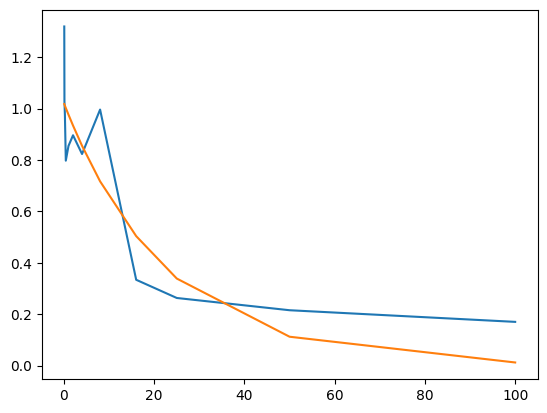

In [41]:
# data from weitz et al
pdurs = [0.06, 0.1, 0.2, 0.4, 1, 2, 4, 8, 16, 25, 50, 100]
major = [835.9723920415021,
651.1969809414203,
609.3258202895763,
623.5526372118089,
608.7881431129291,
592.619678265152,
603.5703145455703,
827.5797115165026,
351.7187374700703,
307.13038515006633,
314.3277221832452,
307.6241015580944]

minor = [103.68606,
 103.68606,
 102.13378,
 127.96016,
 116.52585,
 108.20936,
 119.97071,
 135.95009,
 172.28033,
 190.88661,
 238.53922,
 295.46627]
ys = np.array(major) / np.array(minor)


from scipy.optimize import curve_fit
def fn(x, a, b, c):
    return  b * np.exp(- c * x)

fit = curve_fit(fn, np.array(pdurs), ys)
scal = fn(np.array([0.45]), *fit[0])
fit = curve_fit(fn, np.array(pdurs), ys / scal)
print(list(fit[0]))

y_pred = [fn(np.array([xi]), *fit[0]) for xi in pdurs]
plt.plot(pdurs, np.array(ys) / scal)
plt.plot(pdurs, y_pred)

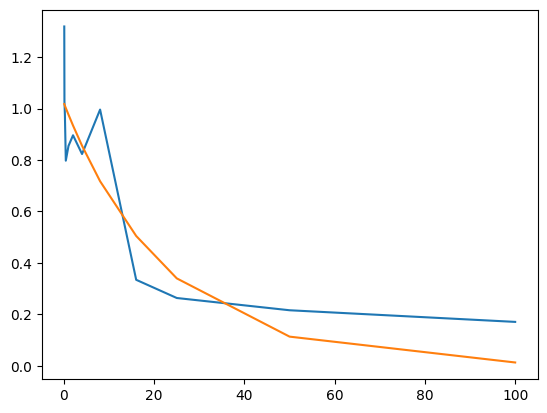

In [42]:
def fn(x):
    return np.exp(x - 0.45)**(-0.044)
y_pred = [fn(np.array([xi])) for xi in pdurs]
plt.plot(pdurs, np.array(ys) / scal)
plt.plot(pdurs, y_pred)

#### Pdur thresh

[0.049915334225081605, 2.111279777923355]
0.6556073129177094


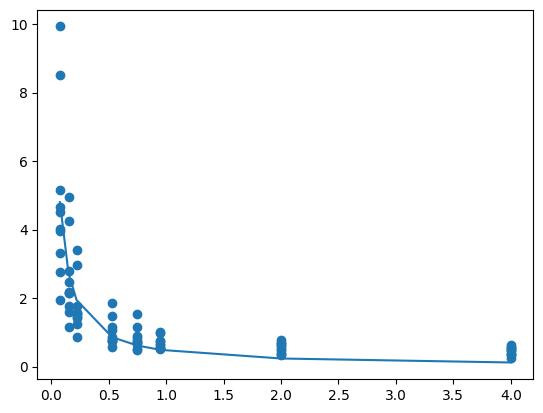

In [43]:
from pulse2percept.datasets import load_horsager2009
from scipy.optimize import curve_fit
data = load_horsager2009(stim_types=['single_pulse'])

def fn(x, a, b):
    return 1 / (a + b * x)

fit = curve_fit(fn, data['pulse_dur'], data['stim_amp'])
scal = fn(0.45, *fit[0])
fit = curve_fit(fn, data['pulse_dur'], data['stim_amp'] / scal)
print(list(fit[0]))

plt.scatter(data['pulse_dur'], data['stim_amp']/scal)

plt.plot(sorted(data['pulse_dur']), [fn(xi, *fit[0]) for xi in sorted(data['pulse_dur'])])
from pulse2percept.utils import r2_score
print(r2_score(data['stim_amp']/scal, [fn(xi, *fit[0]) for xi in data['pulse_dur']]))

[1.0, 2.222222223105992]
0.6483622491359711


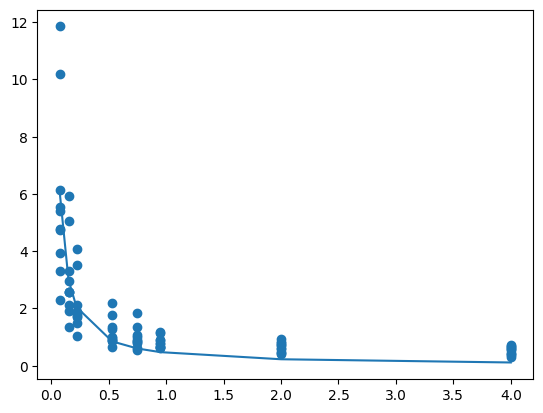

In [44]:
from pulse2percept.datasets import load_horsager2009
from scipy.optimize import curve_fit
data = load_horsager2009(stim_types=['single_pulse'])

def fn(x, a, b):
    return 1 / (b * x)

fit = curve_fit(fn, data['pulse_dur'], data['stim_amp'])
scal = fn(0.45, *fit[0])
fit = curve_fit(fn, data['pulse_dur'], data['stim_amp'] / scal)
print(list(fit[0]))

plt.scatter(data['pulse_dur'], data['stim_amp']/scal)

plt.plot(sorted(data['pulse_dur']), [fn(xi, *fit[0]) for xi in sorted(data['pulse_dur'])])
from pulse2percept.utils import r2_score
print(r2_score(data['stim_amp']/scal, [fn(xi, *fit[0]) for xi in data['pulse_dur']]))

[0.05352205485552976]
0.3254055380821228


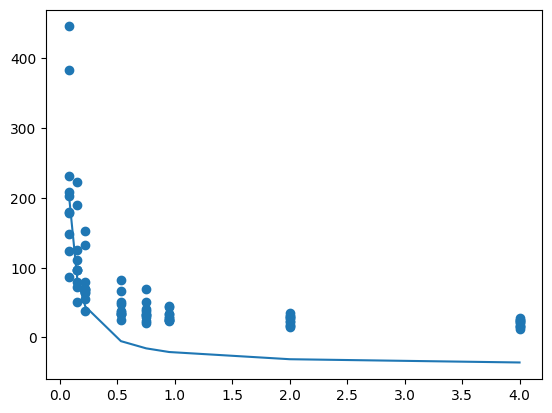

In [61]:
from pulse2percept.datasets import load_horsager2009
from scipy.optimize import curve_fit
data = load_horsager2009(stim_types=['single_pulse'])

def fn(x, b):
    return  (1 - 1/(b*0.45)) + 1 / (b * x)

fit = curve_fit(fn, data['pulse_dur'], data['stim_amp'])
scal = fn(0.45, *fit[0])
fit = curve_fit(fn, data['pulse_dur'], data['stim_amp'] / scal)
print(list(fit[0]))

plt.scatter(data['pulse_dur'], data['stim_amp']/scal)

plt.plot(sorted(data['pulse_dur']), [fn(xi, *fit[0]) for xi in sorted(data['pulse_dur'])])
from pulse2percept.utils import r2_score
print(r2_score(data['stim_amp']/scal, [fn(xi, *fit[0]) for xi in data['pulse_dur']]))

In [57]:
1 - 1/(0.45 * 4.7272)

0.5299072977191102

In [55]:
fn(100, *fit[0])

0.22026767244682247

In [58]:
0.2181 + 1 /(4.7272*0.45)

0.6881927022808898